# Functional Connectivity of Attention Networks During Animated Stories in Preschool Aged Children

# BACKGROUND 

The National Education Association prompts parents to build a daily habit of reading and modeling for their children to raise “readers”. This research project outlines implications of educational media design, classroom practices, and parental recommendations. It directly relates to how children learn, understand, and engage with information. 

This research investigates how different types of story media modalities, like audio storytelling, video animations, and still-print books, affect children’s brain activity, like attention, and comprehension. Using functional near-infrared spectroscopy (fNIRS), a non-invasive brain imaging technique that detects changes in blood oxygenation and volume in the cortex, I measure real-time activity of the prefrontal cortex (PFC) while children engage with the media. The PFC is associated with executive function, attention, and working memory, key components of learning. Executive function arises from coordinated activity between brain regions, especially within the prefrontal and parietal cortices. This coordination, called functional connectivity, enables the brain to manage attention, control impulses, and flexibly shift between tasks. Stronger functional connectivity also supports reading comprehension by helping children focus, integrate information, and make meaning from complex narratives. By examining how neural activation and synchrony vary across different story formats, and how these patterns relate to behavioral measures like reading level and comprehension, my work aims to uncover how media shape cognitive engagement. This research has implications for education, developmental psychology, and media design, helping to inform practices that support children’s learning and brain development.

The data below is a pilot study of the animated video books read by the Carnegie Mellon Children’s School 4s and Ks classrooms. The full length study of all three media types will begin this summer. 



# VARIABLES

**1. Independent Variables:**

- **Story Book** (5 stories)
  - Narwhal
  - Why Do Flowers Grow?
  - My Dog Thinks I'm A Genius
  - Mouse House
  - Little Sock Makes A Friend

- **Story Media Type** (for after pilot testing)
  - Video animated book
  - Interactive book
  - Audiobook

- **Participant Characteristics** *(grouping variables)*:
  - Age (continuous)
  - Classroom (binary: 4s/Ks)
 
**2. Dependent Variables:**
- **Neural**
  - Prefrontal Activation (HbO/HbR levels)
  - Inter-subject Synchrony (especially in dyads or groups)
  - Functional Connectivity (within and across prefrontal regions)

- **Behavioral/Cognitive:**
  - Comprehension scores (0-8 points)
 
**3. Within-Subject:**
- All students are in the video animated media type for the pilot testing. Some participants (N = 11) watched 2 different stories. 



# Data Organization:


# Data Cleaning
1. Import packages.
2. Load in data. The snirf file starts with values in raw intensity. (fNIRS is a light measurement tool)
3. Visualize coordinates to validate the location of source-detector pairs and channels are in the proper locations. 
4. Convert from raw intensity to optical density. 
5. Check scalp coupling index (SCI) to mark and remove bad channels. We must quantify the quality of the coupling between the scalp and the optodes. This removes synchronous singles that are in the same frequency range as cardiac signals. My SCI exclusionary number is 0.5. 
6. Apply temporal derivative distribution repair (TDDR) on raw optical density. This removes the baseline shift of the data and removes movement artifacts. 
7. High pass filter. Move from unfiltered (raw) optical density to high filtered optical density. Keep high frequency information and reject low frequency information by defining boundaries. We want the haemodynamic response which has a frequency predominantly around 0.5 Hz, so we need to remove below a predetermined threshold and will eliminate slow drifts in the data.

# Analysis #1: PCA
8. Short channel regression or principal component analysis. The short channel regression is a systemic correction regression based on the nearest short channel under the defined boundary range 0.1cm. This reduces measurements of extracerebral data because the measurement isn’t deep enough to pick up cerebral activity. It’s essential in high noise environments, like working with kids due to them being movement-prone participants and when the region of interest is close to the surface, like the prefrontal cortex. In the first half of our data collection, our short channels were not being recorded, thus we can use principal component analysis to mimic short channel regression. It also identifies and removes components of the fNIRS signal that are dominated by global or superficial physiological noise. Superficial signals tend to be both global and have high variance so they dominate the signal across many channels. By removing the top principal component we’re regressing out the global noise in a similar fashion to what the short channels would pick up. 
9. Low-pass filter the data. Remove any leftover activity from a person’s heart beat at around 1 Hz. 
10. Apply the modified beer lambert law. Turn filtered optical density into filtered haemoglobin concentration. ​​The units of change are in micromolar. This is then used in the correlation matrices that prompt connectedness of channels (functional connectivity). 



# Hypotheses
H1. Book-Specific Neural Pattern Hypothesis

There are significant differences in functional connectivity (FC) between participants who read different books. Specifically, the brain connectivity patterns of participants will vary based on the type of story content they engage with, suggesting that different types of narrative content (e.g., narwhal, sock, mouse, dog, flowers) influence the neural networks involved in attention, comprehension, and cognitive processing. More specifically, we hypothesize that groups reading different books will show distinct functional connectivity patterns, with some books potentially eliciting stronger or more distinct brain activity associated with story comprehension and engagement than others. These differences in functional connectivity may reflect how different story elements influence brain regions involved in processing narratives and sensory information.

H2. Comprehension-Aligned Representation Hypothesis

Null: The combination of age, grade, and books read does not significantly predict comprehension. This means that the model as a whole does not explain a significant portion of the variability in the comprehension scores.

Comprehension = $C$

Error term = $\epsilon$

$C = \beta_0 + \beta_1*AgeMonths + \beta_2*Grade_K + \beta_3*BookArtDog + \beta_4*BookFlowers + \beta_5*BookLittleSock + \beta_6*BookMouseHouse + \beta_7*BookNarwhal + \epsilon$



In [212]:
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
import os
import statsmodels.api as sm

current_working_directory = os.getcwd()

# Print the current working directory
print(current_working_directory)

file_path = '/Users/mdavistr/Desktop/fnirs_comprehension_data.xlsx'  # Adjust the path if needed after upload

comp_data = pd.read_excel(file_path)

comp_data['Birthday'] = pd.to_datetime(comp_data['Birthday'], errors='coerce')
comp_data['Date'] = pd.to_datetime(comp_data['Date'], errors='coerce')
# Compute age in months
comp_data['Age_months'] = ((comp_data['Date'] - comp_data['Birthday']).dt.days / 30.44).round(1) 

#print(comp_data.head())


# Dummy code grade and book watched 
comp_data['Grade_K'] = (comp_data['Grade'] == 'K').astype(int)
df_books_dummies = pd.get_dummies(comp_data['book_watched'], prefix='Book')
df_combined = pd.concat([comp_data, df_books_dummies], axis=1)
df_combined['Book_Art dog'] = df_combined['Book_Art dog'].astype(int)
df_combined['Book_Flowers'] = df_combined['Book_Flowers'].astype(int)
df_combined['Book_Little Sock'] = df_combined['Book_Little Sock'].astype(int)
df_combined['Book_Mouse House'] = df_combined['Book_Mouse House'].astype(int)
df_combined['Book_Narwhal'] = df_combined['Book_Narwhal'].astype(int)


#print(df_combined)
#df_combined.to_excel('fnirs_comprehension_CHECK.xlsx', index=False)

X = df_combined[['Age_months', 'Grade_K', 'Book_Art dog',	'Book_Flowers',	'Book_Little Sock',	'Book_Mouse House',	'Book_Narwhal']]
X = sm.add_constant(X)  
Y = df_combined['score_output']

#print(df_combined[['Age_months', 'Grade_K', 'Book_Art dog', 'Book_Flowers', 'Book_Little Sock', 'Book_Mouse House', 'Book_Narwhal']].dtypes)

# Fit the model using OLS (Ordinary Least Squares)
model = sm.OLS(Y, X).fit()
print(model.summary())



/Users/mdavistr/Desktop/fnirs_data
                            OLS Regression Results                            
Dep. Variable:           score_output   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     2.880
Date:                Thu, 01 May 2025   Prob (F-statistic):             0.0239
Time:                        21:01:42   Log-Likelihood:                -66.516
No. Observations:                  38   AIC:                             147.0
Df Residuals:                      31   BIC:                             158.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const

# Analysis #2: Linear Regression
A multiple linear regression was conducted to examine whether children's age in months, grade level, and the specific book they read predicted their comprehension scores. The overall model was statistically significant, F(6, 31) = 2.88, p = .024, explaining approximately 36% of the variance in comprehension scores (R² = .358, adjusted R² = .234). None of the individual predictors reached conventional significance levels, though the book Narwhal showed a marginally significant negative association with comprehension (β = -1.68, p = .086), suggesting children who read Narwhal may have scored lower on comprehension compared to the reference book. Age in months had a positive but non-significant relationship with comprehension (β = 0.092, p = .278), and being in kindergarten versus pre-k(4's classroom) did not significantly predict comprehension scores (β = -0.022, p = .983). Other books also showed no significant differences in predicted comprehension scores. These results suggest that while the combination of predictors accounts for a moderate proportion of the variance in comprehension, no single factor emerged as a robust predictor in this model.

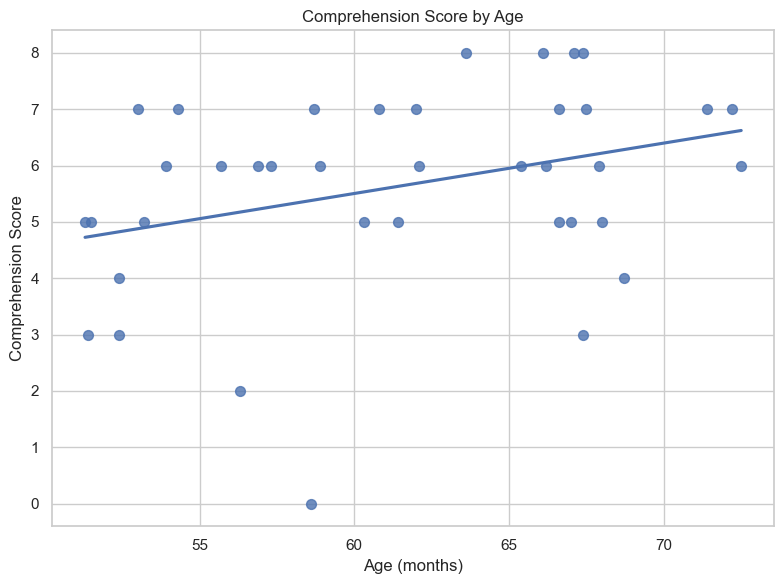

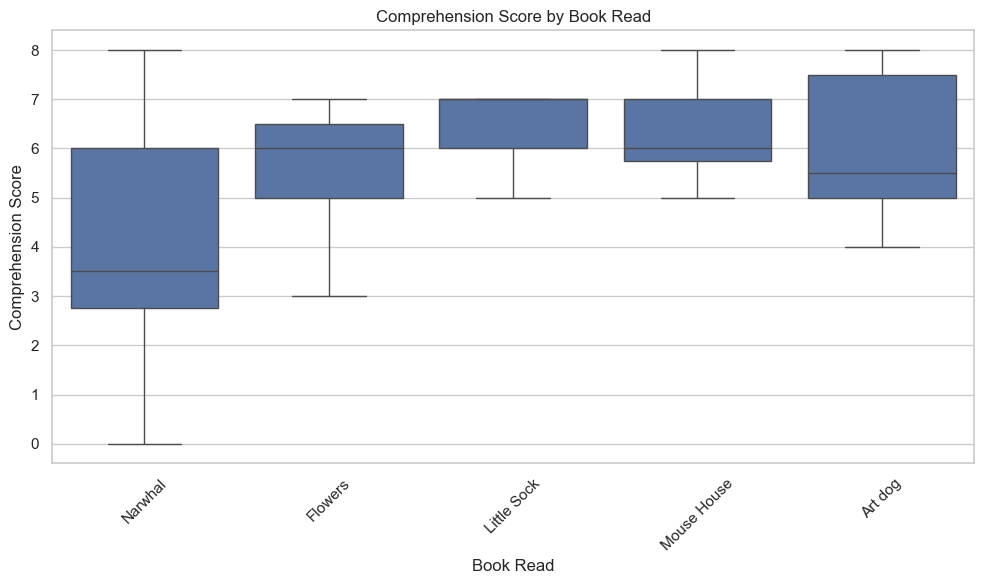

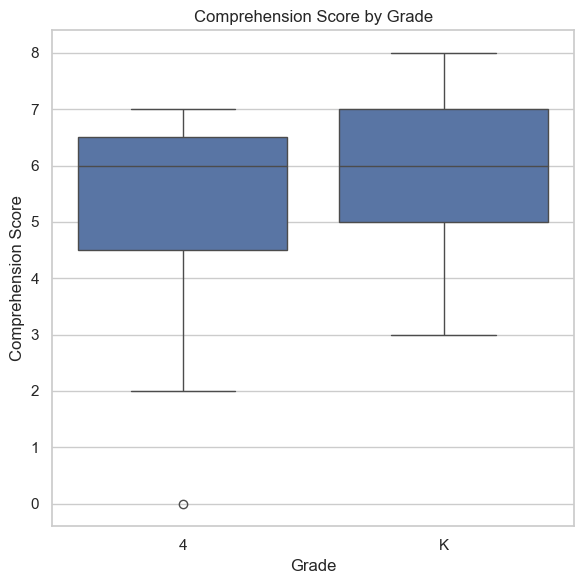

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- 1. Comprehension by Age (scatterplot + regression line) ---
plt.figure(figsize=(8, 6))
sns.regplot(data=df_combined, x="Age_months", y="score_output", ci=None, scatter_kws={'s': 50})
plt.title("Comprehension Score by Age")
plt.xlabel("Age (months)")
plt.ylabel("Comprehension Score")
plt.tight_layout()
plt.show()

# --- 2. Comprehension by Book Read (boxplot) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x="book_watched", y="score_output")
plt.title("Comprehension Score by Book Read")
plt.xlabel("Book Read")
plt.ylabel("Comprehension Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 3. Comprehension by Grade (boxplot) ---
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_combined, x="Grade", y="score_output")
plt.title("Comprehension Score by Grade")
plt.xlabel("Grade")
plt.ylabel("Comprehension Score")
plt.tight_layout()
plt.show()

In [5]:
# 1 import packages
%matplotlib inline

from itertools import compress

import os
import matplotlib.pyplot as plt
import numpy as np

import mne
import mne_nirs


----- Processing: 2025-03-17_001.snirf -----
2025-03-17_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-17_001.snirf
Reading 0 ... 4498  =      0.000 ...   442.153 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



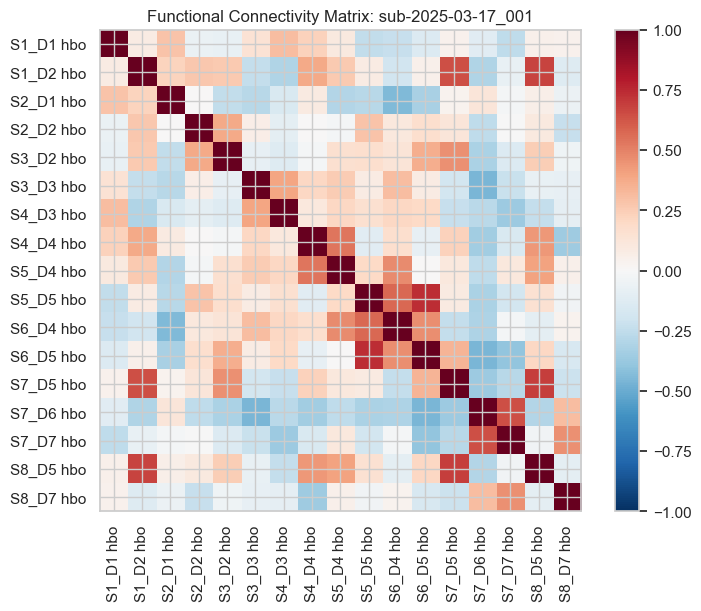


----- Processing: 2025-04-17_001.snirf -----
2025-04-17_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-17_001.snirf
Reading 0 ... 5423  =      0.000 ...   533.081 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



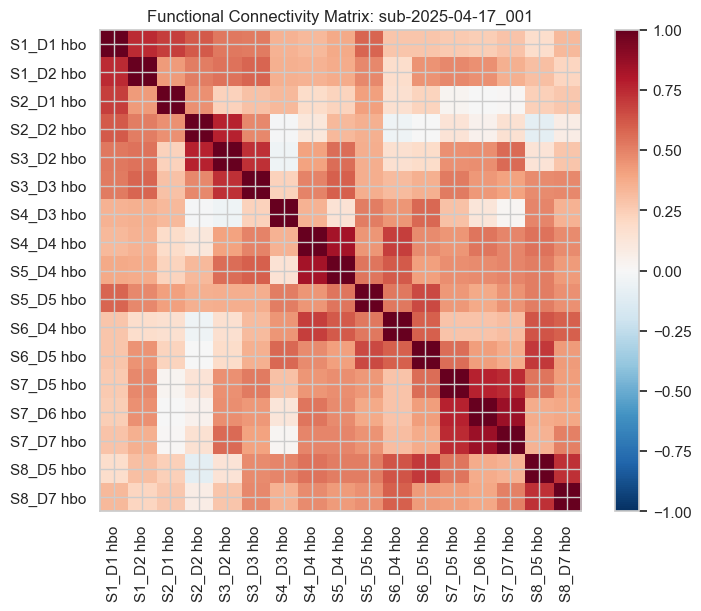


----- Processing: 2025-02-25_002.snirf -----
2025-02-25_002
Loading /Users/mdavistr/Desktop/fnirs_data/2025-02-25_002.snirf
Reading 0 ... 4622  =      0.000 ...   454.343 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



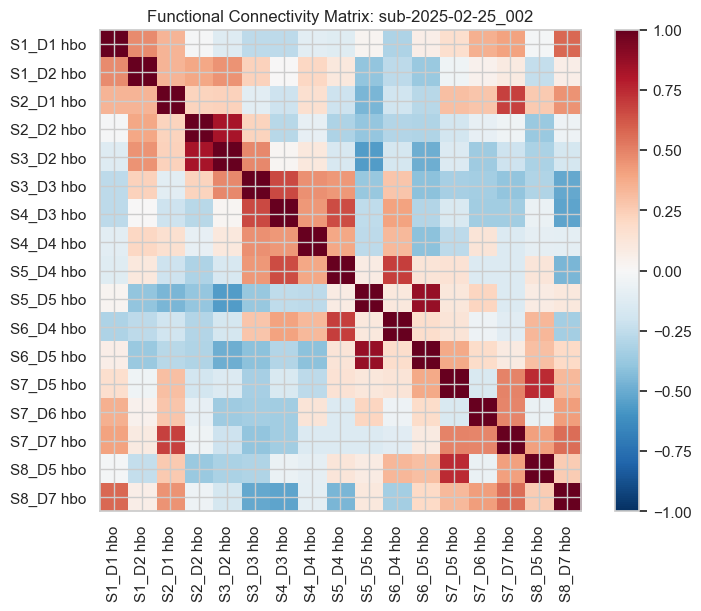


----- Processing: 2025-04-08_001.snirf -----
2025-04-08_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-08_001.snirf
Reading 0 ... 4113  =      0.000 ...   404.308 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



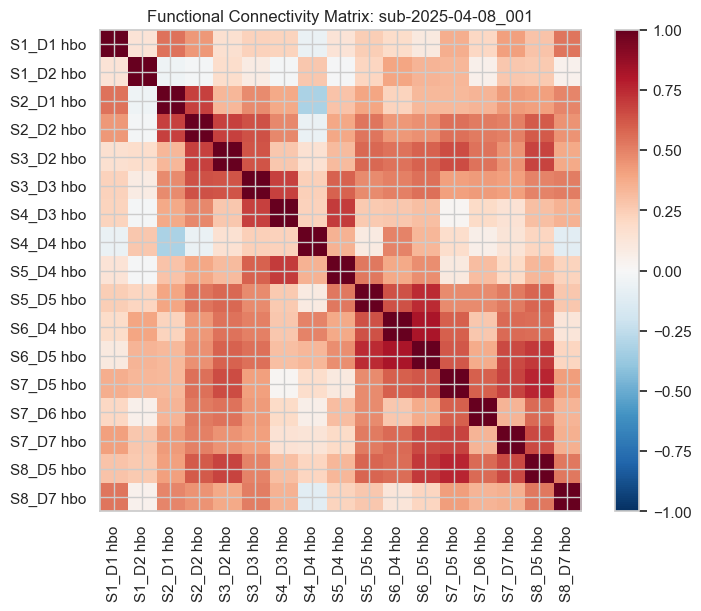


----- Processing: 2025-03-24_001.snirf -----
2025-03-24_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-24_001.snirf
Reading 0 ... 4123  =      0.000 ...   405.291 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



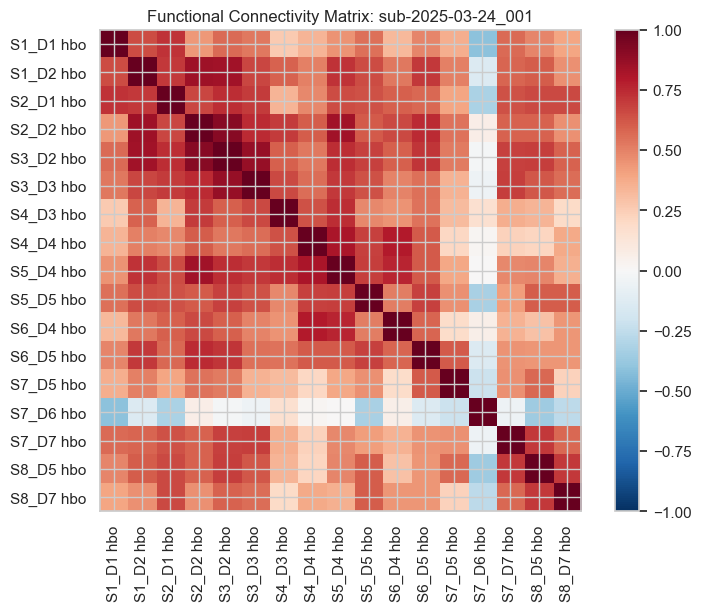


----- Processing: 2025-03-11_001.snirf -----
2025-03-11_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-11_001.snirf
Reading 0 ... 4581  =      0.000 ...   450.312 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



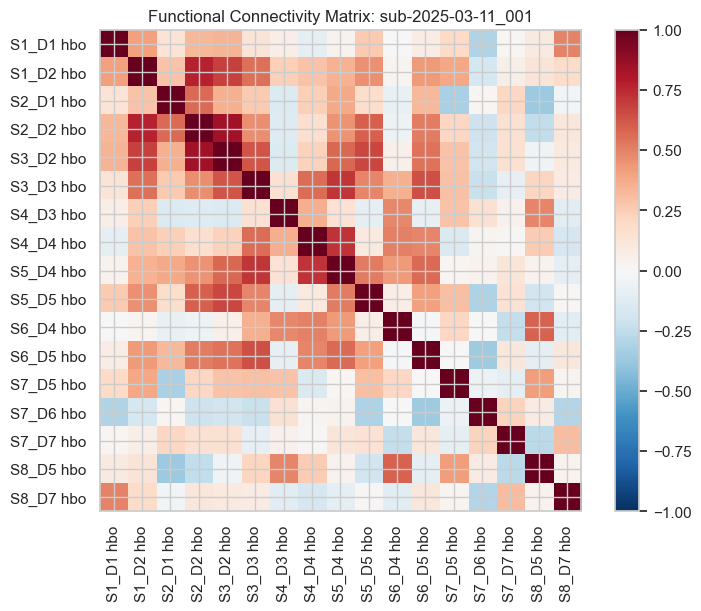


----- Processing: 2025-03-25_002.snirf -----
2025-03-25_002
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-25_002.snirf
Reading 0 ... 3963  =      0.000 ...   389.563 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



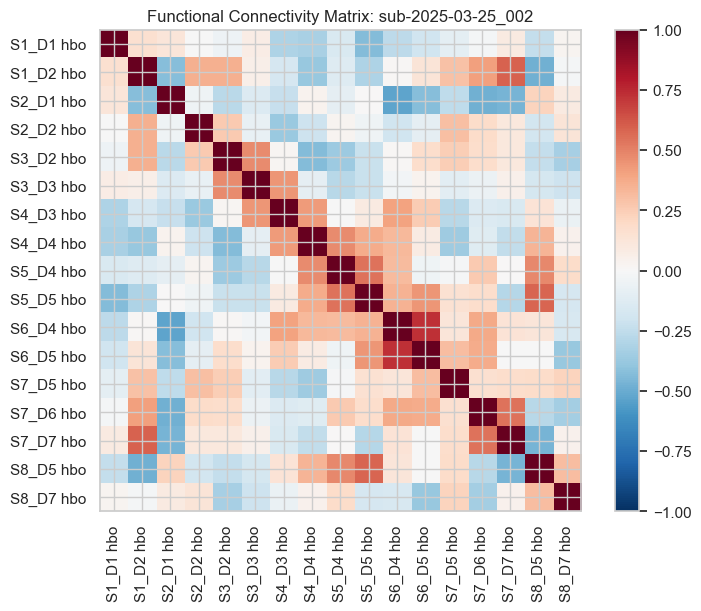


----- Processing: 2025-04-02_001.snirf -----
2025-04-02_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-02_001.snirf
Reading 0 ... 4182  =      0.000 ...   411.091 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



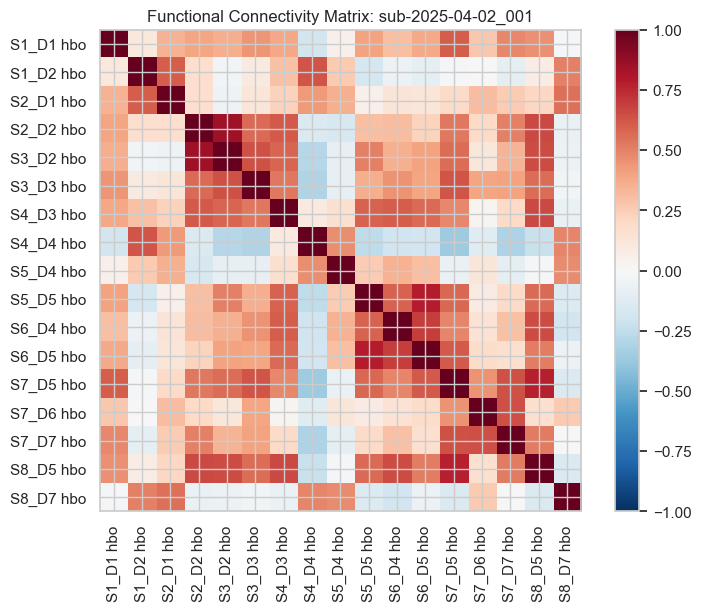


----- Processing: 2025-04-16_001.snirf -----
2025-04-16_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-16_001.snirf
Reading 0 ... 4911  =      0.000 ...   482.751 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



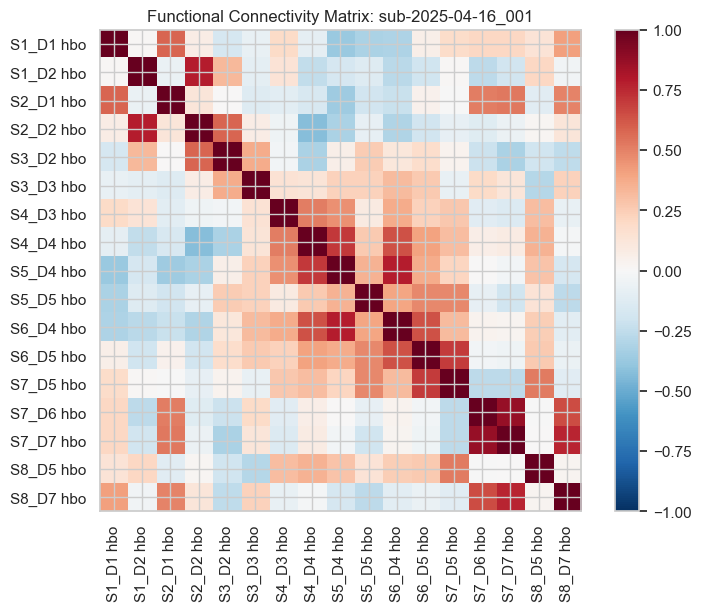


----- Processing: 2025-04-17_002.snirf -----
2025-04-17_002
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-17_002.snirf
Reading 0 ... 4072  =      0.000 ...   400.278 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



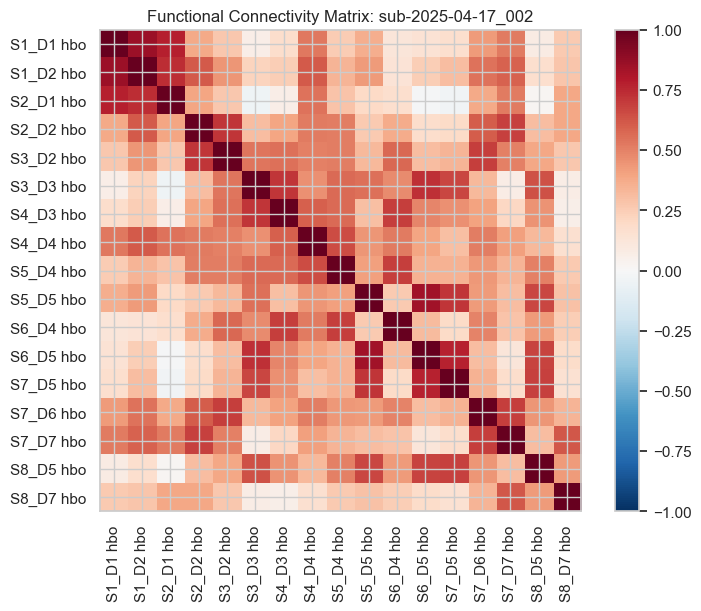


----- Processing: 2025-02-25_001.snirf -----
2025-02-25_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-02-25_001.snirf
Reading 0 ... 4367  =      0.000 ...   429.276 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



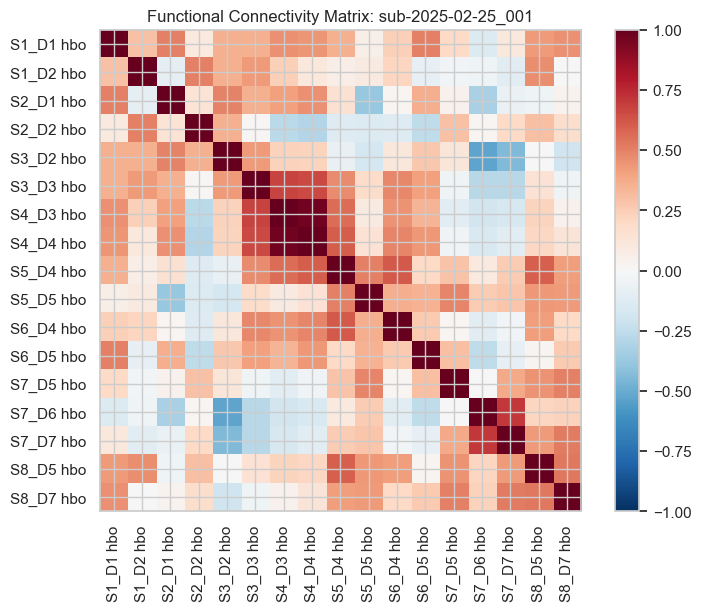


----- Processing: 2025-04-09_001.snirf -----
2025-04-09_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-09_001.snirf
Reading 0 ... 4236  =      0.000 ...   416.399 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



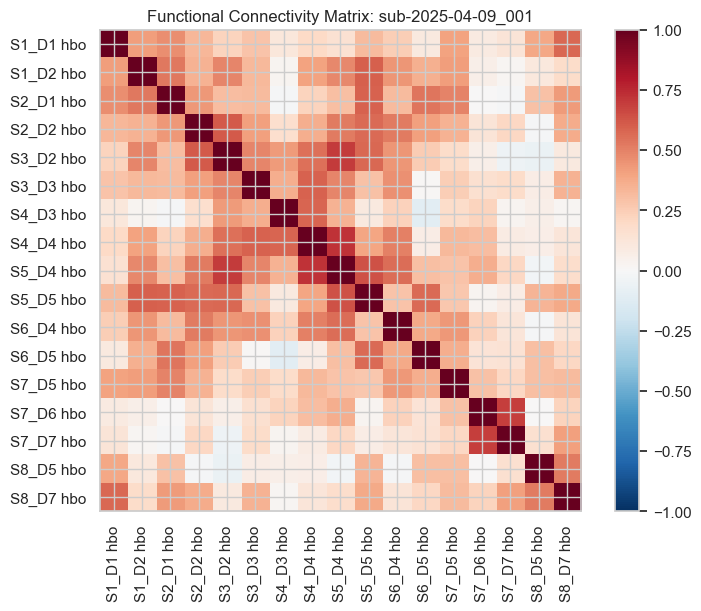


----- Processing: 2025-03-11_002.snirf -----
2025-03-11_002
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-11_002.snirf
Reading 0 ... 3926  =      0.000 ...   385.926 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



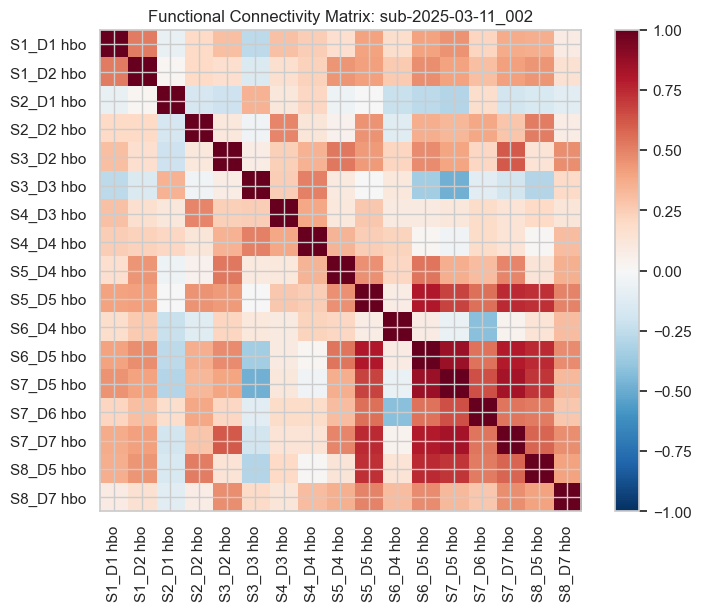


----- Processing: 2025-03-25_001.snirf -----
2025-03-25_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-25_001.snirf
Reading 0 ... 6667  =      0.000 ...   655.366 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



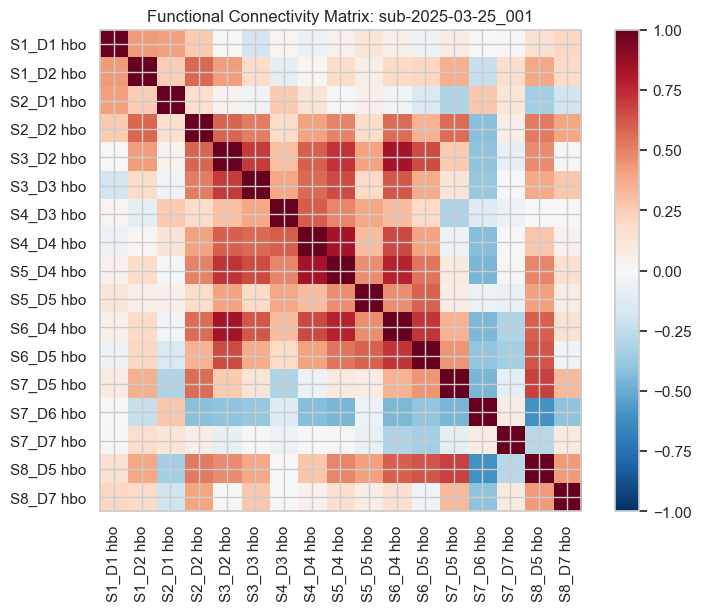


----- Processing: 2025-04-10_001.snirf -----
2025-04-10_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-10_001.snirf
Reading 0 ... 5664  =      0.000 ...   556.771 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



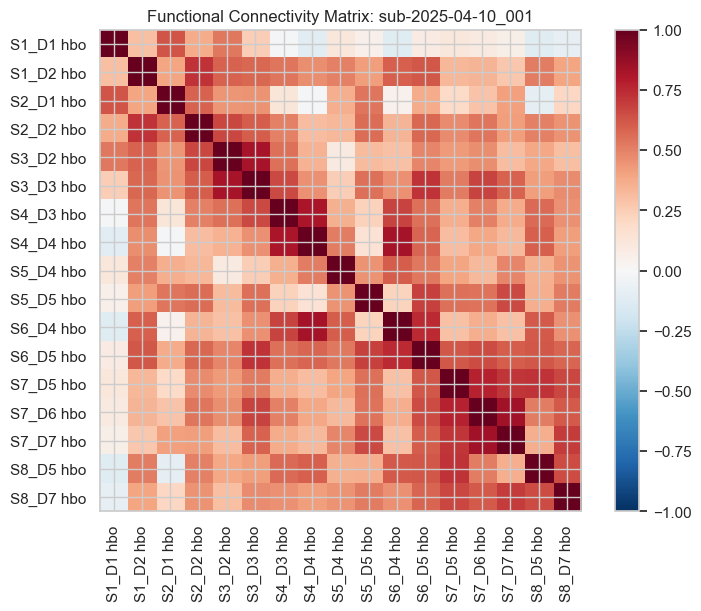


----- Processing: 2025-03-10_001.snirf -----
2025-03-10_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-10_001.snirf
Reading 0 ... 4717  =      0.000 ...   463.681 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



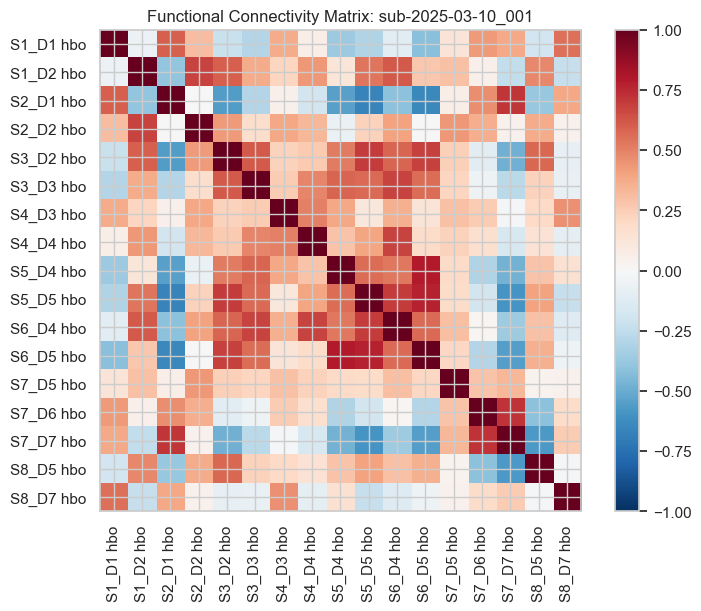


----- Processing: 2025-03-18_001.snirf -----
2025-03-18_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-18_001.snirf
Reading 0 ... 4988  =      0.000 ...   490.320 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



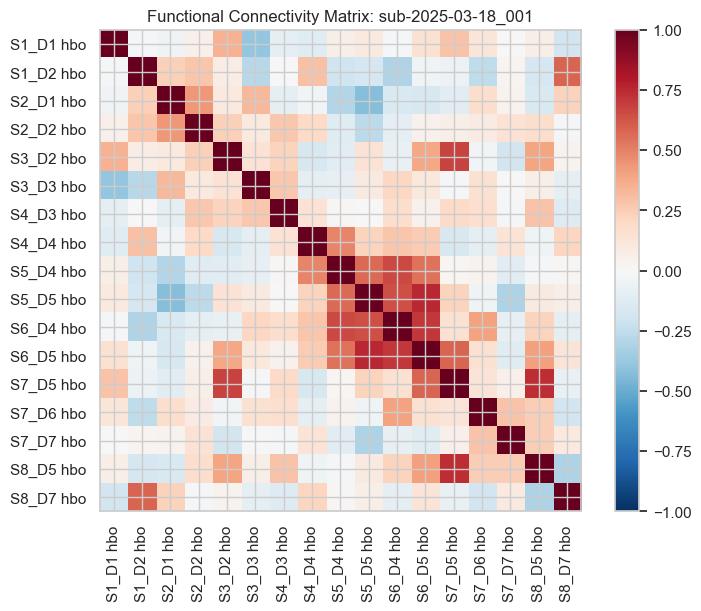


----- Processing: 2025-03-20_001.snirf -----
2025-03-20_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-20_001.snirf
Reading 0 ... 4828  =      0.000 ...   474.592 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



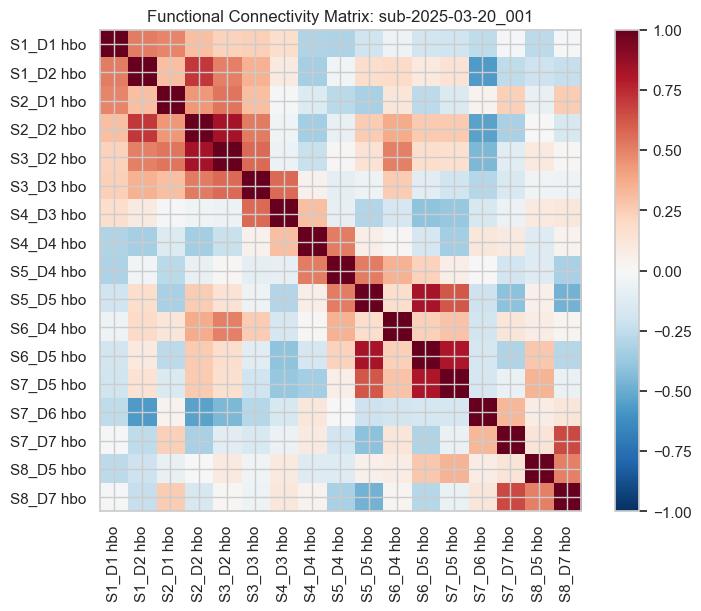


----- Processing: 2025-04-15_001.snirf -----
2025-04-15_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-15_001.snirf
Reading 0 ... 4139  =      0.000 ...   406.864 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



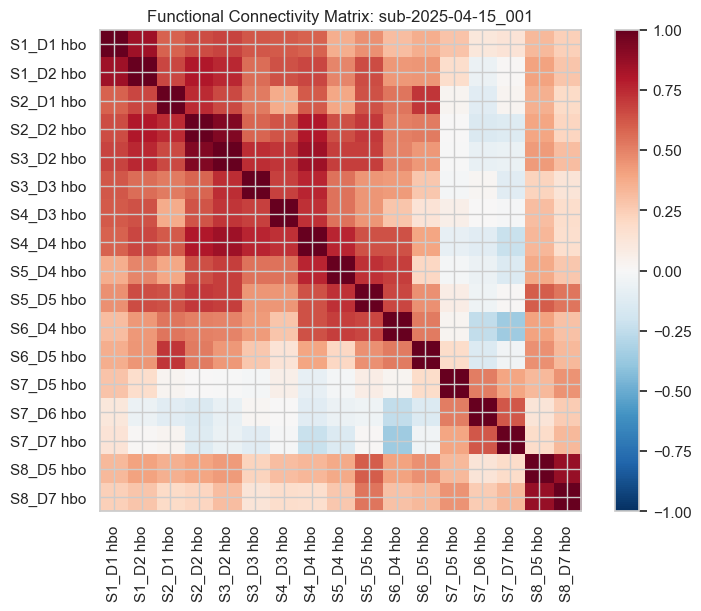


----- Processing: 2025-04-01_001.snirf -----
2025-04-01_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-01_001.snirf
Reading 0 ... 4531  =      0.000 ...   445.397 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



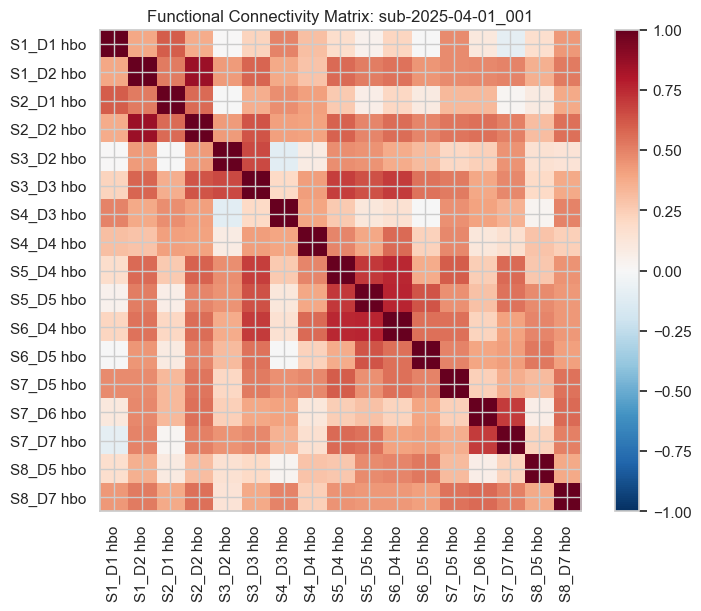


----- Processing: 2025-04-21_002.snirf -----
2025-04-21_002
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-21_002.snirf
Reading 0 ... 5054  =      0.000 ...   496.808 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



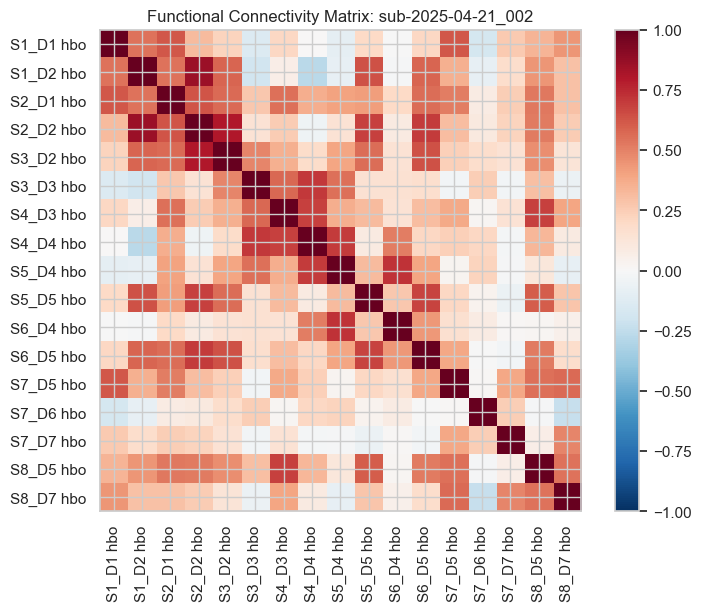


----- Processing: 2025-04-07_001.snirf -----
2025-04-07_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-07_001.snirf
Reading 0 ... 4866  =      0.000 ...   478.328 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



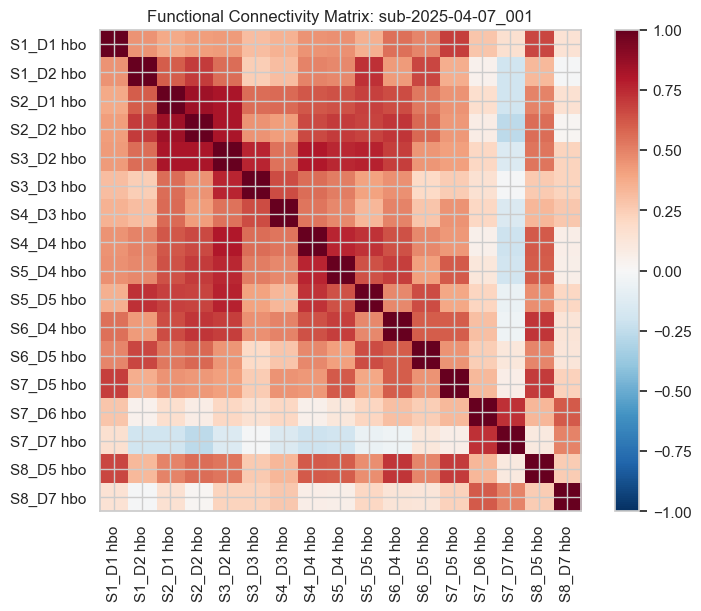


----- Processing: 2025-03-26_001.snirf -----
2025-03-26_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-26_001.snirf
Reading 0 ... 4461  =      0.000 ...   438.516 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



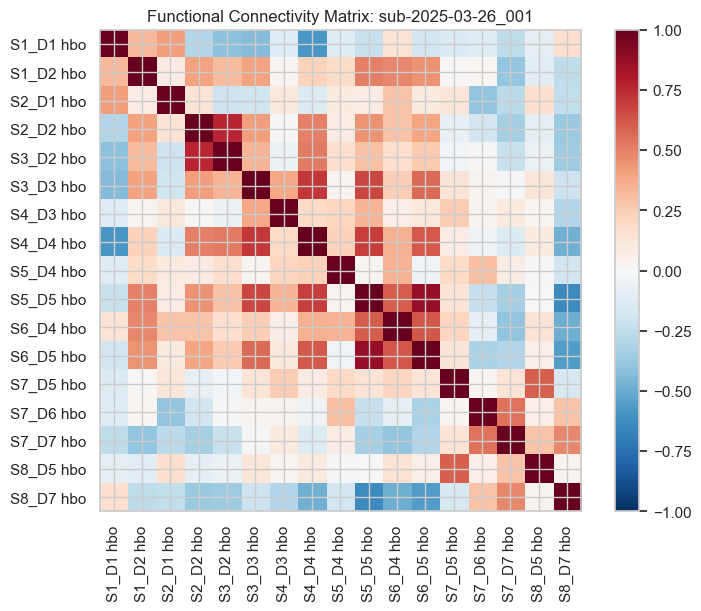


----- Processing: 2025-03-12_002.snirf -----
2025-03-12_002
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-12_002.snirf
Reading 0 ... 7309  =      0.000 ...   718.475 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



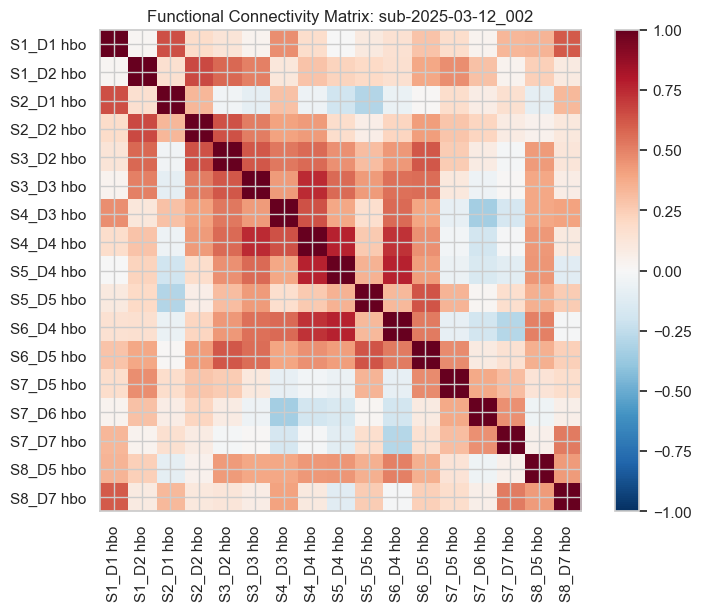


----- Processing: 2025-04-15_002.snirf -----
2025-04-15_002
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-15_002.snirf
Reading 0 ... 7158  =      0.000 ...   703.631 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



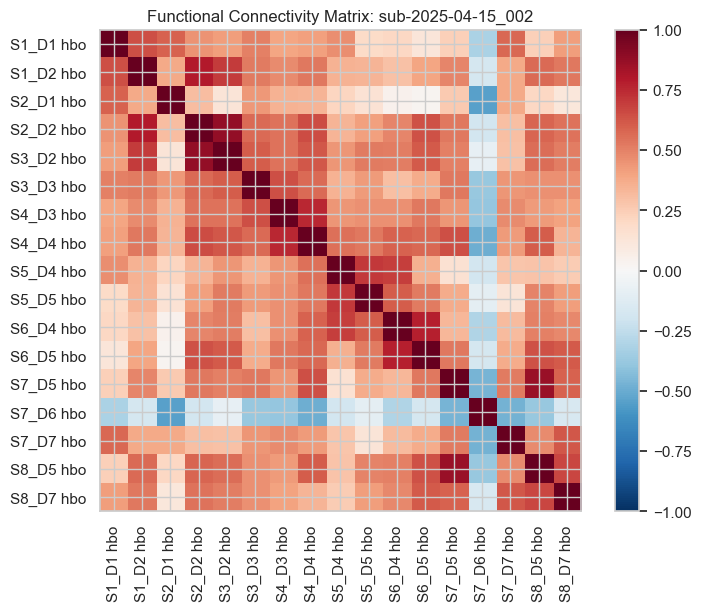


----- Processing: 2025-04-21_001.snirf -----
2025-04-21_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-21_001.snirf
Reading 0 ... 5253  =      0.000 ...   516.370 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



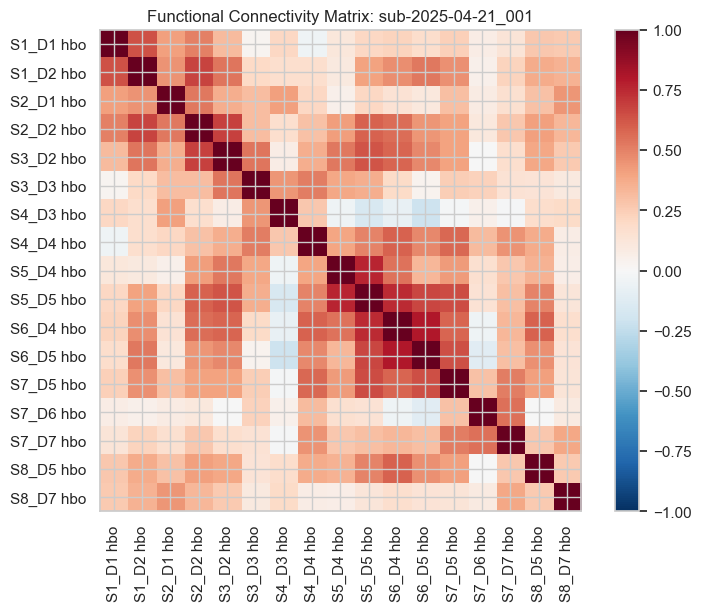


----- Processing: 2025-02-27_001.snirf -----
2025-02-27_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-02-27_001.snirf
Reading 0 ... 6277  =      0.000 ...   617.029 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



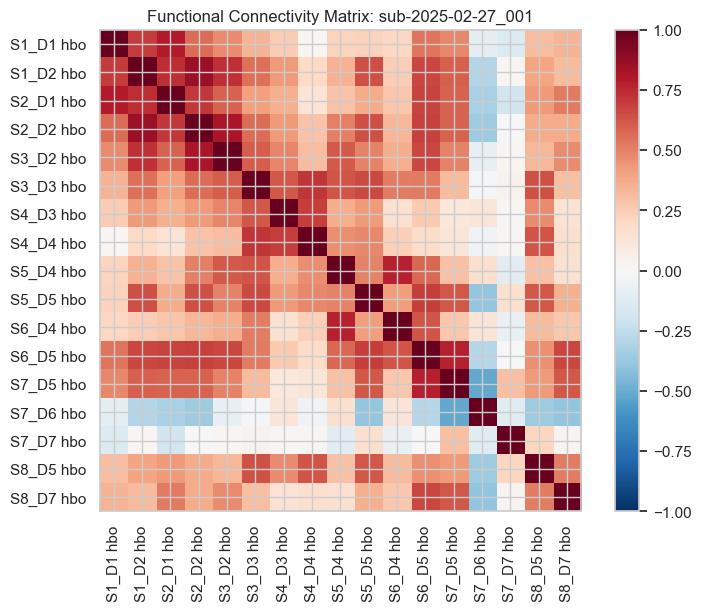


----- Processing: 2025-04-14_001.snirf -----
2025-04-14_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-14_001.snirf
Reading 0 ... 4672  =      0.000 ...   459.258 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



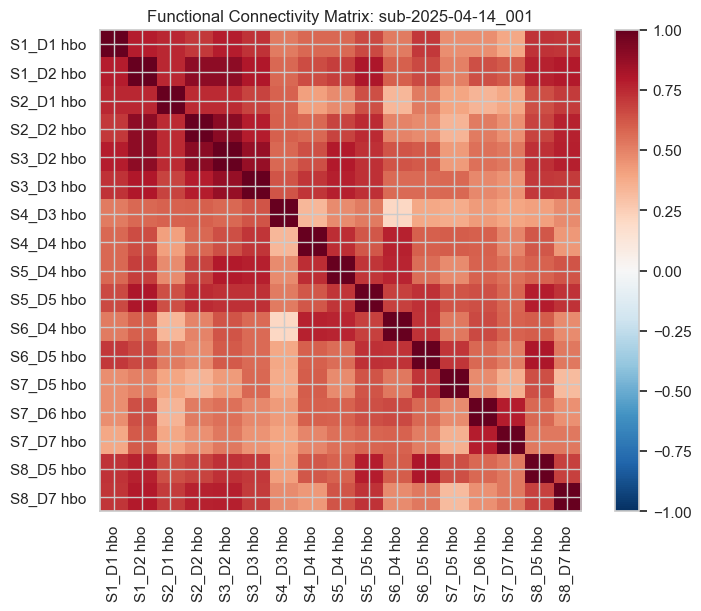


----- Processing: 2025-03-12_001.snirf -----
2025-03-12_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-12_001.snirf
Reading 0 ... 4683  =      0.000 ...   460.339 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



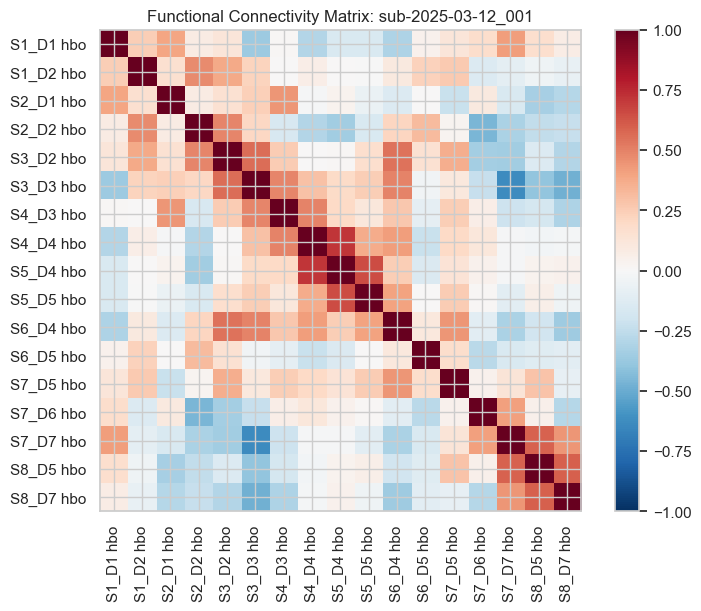


----- Processing: 2025-04-07_002.snirf -----
2025-04-07_002
Loading /Users/mdavistr/Desktop/fnirs_data/2025-04-07_002.snirf
Reading 0 ... 5256  =      0.000 ...   516.665 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



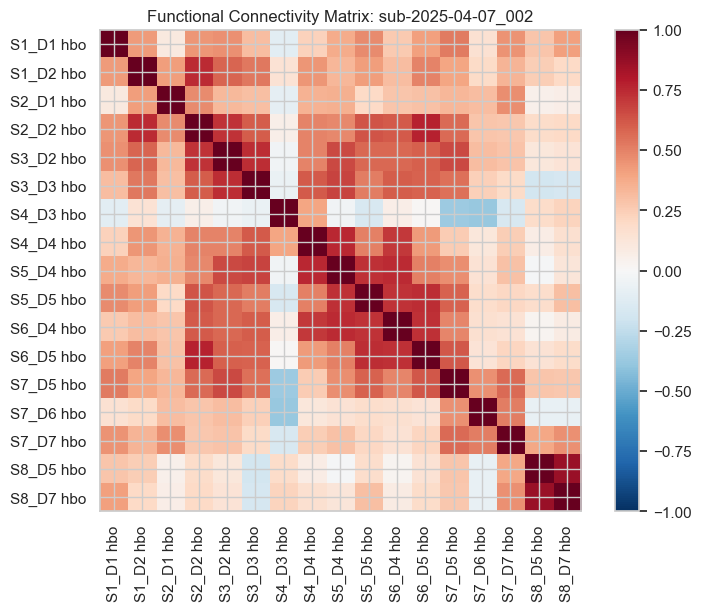


----- Processing: 2025-03-27_001.snirf -----
2025-03-27_001
Loading /Users/mdavistr/Desktop/fnirs_data/2025-03-27_001.snirf
Reading 0 ... 4119  =      0.000 ...   404.898 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.01 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.30 Hz: -6.02 dB



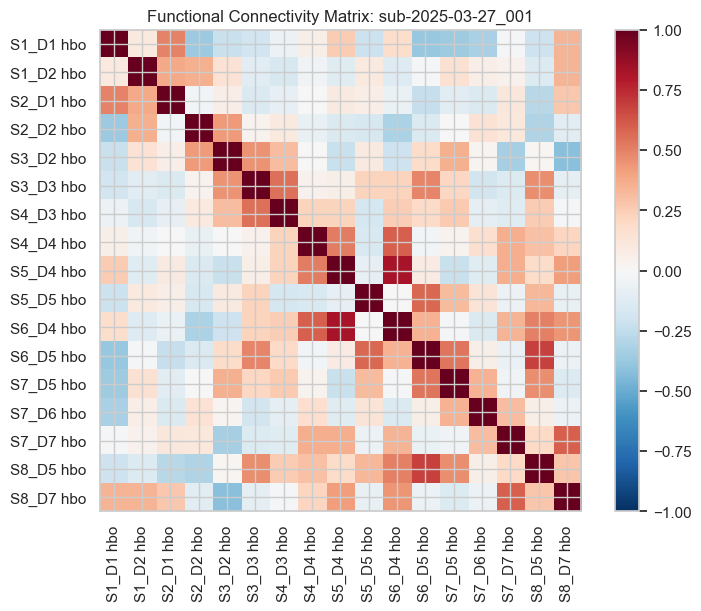

In [214]:
snirf_files = [f for f in os.listdir(fnirs_data_folder) if f.endswith(".snirf")]
all_corr_matrices = []

short_corr_matrices = ["2025-04-01_001", "2025-04-02_001", "2025-04-07_001", "2025-04-07_002", "2025-04-09_001", "2025-04-08_001", "2025-04-10_001", "2025-04-14_001", "2025-04-15_001", "2025-04-15_002", "2025-04-16_001", "2025-04-17_001", "2025-04-17_002", "2025-04-21_001", "2025-04-21_002", "2025-04-22_001", "2025-04-22_002"]
k_corr_matrices = ["2025-04-01_001", "2025-04-02_001", "2025-04-07_001", "2025-04-07_002", "2025-04-08_001", "2025-04-09_001", "2025-04-15_001", "2025-04-16_001", "2025-04-17_002", "2025-04-21_001", "2025-03-12_001", "2025-03-12_002", "2025-03-17_001", "2025-03-18_001", "2025-03-24_001", "2025-03-25_002", "2025-03-26_001", "2025-03-27_001"]
four_corr_matrices = ["2025-04-10_001", "2025-04-14_001", "2025-04-15_002", "2025-04-17_001", "2025-04-21_002", "2025-04-22_001", "2025-04-22_002", "2025-02-25_001", "2025-02-25_002", "2025-02-27_001", "2025-03-10_001", "2025-03-11_001", "2025-03-11_002", "2025-03-20_001", "2025-03-25_001"]
flowers_corr_matrices = ["2025-04-15_001", "2025-02-25_002", "2025-03-11_001", "2025-03-11_002", "2025-03-20_001", "2025-03-27_001"]
mouse_corr_matrices = ["2025-04-07_001", "2025-04-07_002", "2025-04-10_001", "2025-04-16_001", "2025-03-17_001", "2025-03-25_001", "2025-03-26_001"]
narwhal_corr_matrices = ["2025-04-01_001", "2025-04-08_001", "2025-04-14_001", "2025-04-17_002", "2025-02-25_001", "2025-02-27_001", "2025-03-10_001", "2025-03-25_002"]
sock_corr_matrices = ["2025-04-02_001", "2025-04-09_001", "2025-04-15_002", "2025-04-22_001", "2025-03-12_001", "2025-03-12_002", "2025-03-18_001", "2025-03-24_001"]
dog_corr_matrices = ["2025-04-17_001", "2025-04-21_001", "2025-04-21_002", "2025-04-22_002"]

book_groups = {
    "flowers": flowers_corr_matrices,
    "mouse": mouse_corr_matrices,
    "narwhal": narwhal_corr_matrices,
    "sock": sock_corr_matrices,
    "dog": dog_corr_matrices
}

age_groups = {
    "k": k_corr_matrices,
    "four": four_corr_matrices,
}






for snirf_file in snirf_files:
    print(f"\n----- Processing: {snirf_file} -----")
    subdate = snirf_file.split(".")[0]

    #filtering the group
    #if (subdate in sock_corr_matrices):
    #    print(subdate)
    #else:
    #    continue

    print(subdate)

    snirf_path = os.path.join(fnirs_data_folder, snirf_file)
    raw_intensity = mne.io.read_raw_snirf(snirf_path, preload=True)  

    raw_intensity.annotations.set_durations(5)
    if (subdate == "2025-03-11_002"):
        raw_intensity.annotations.rename({"2": "vid_end"})
    else: 
        raw_intensity.annotations.rename({"1": "vid_start", "2": "vid_end"})
    unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
    raw_intensity.annotations.delete(unwanted)

    
    # crop to video section
    start_time = None
    end_time = None
    
    for desc, onset in zip(raw_intensity.annotations.description, raw_intensity.annotations.onset):
        if desc == "vid_start":
            start_time = onset
        elif desc == "vid_end":
            end_time = onset

    if subdate == "2025-03-11_002":
        start_time = 0
    
    if start_time is not None and end_time is not None:
        video_raw_intensity = raw_intensity.copy().crop(tmin=start_time, tmax=end_time)
    else:
        raise ValueError("Start or End annotation not found.")
    
    # 3 visualize time courses, sensors
    
    #for viewing data of brain sensors overlaid on head
    
    #subjects_dir = mne.datasets.sample.data_path() / "subjects" # CHANGE THIS
    #subjects_dir = "C:/Users/piano/Box/Lab Manager/ILLL/FNIRS/data"
    #will be set to our subject directory
    
    #brain = mne.viz.Brain(
    #    "fsaverage", subjects_dir=subjects_dir, background="w", cortex="0.5"
    #)
    #brain.add_sensors(
    #    video_raw_intensity.info,
    #    trans="fsaverage",
    #    fnirs=["channels", "pairs", "sources", "detectors"],
    #)
    #brain.show_view(azimuth=20, elevation=60, distance=400)

    
    # 4 convert intensity to opticaldensity
    #find changes in deoxy and oxy bld
    
    picks = mne.pick_types(video_raw_intensity.info, meg=False, fnirs=True)
    dists = mne.preprocessing.nirs.source_detector_distances(
        video_raw_intensity.info, picks=picks
    )
    #raw_intensity.pick(picks[dists > 0.01]) #the line is get long channels early 
    #video_raw_intensity.plot(
        #n_channels=len(video_raw_intensity.ch_names), duration=500, show_scrollbars=False
    #)
    
    
    # 4 convert intensity to optical density 
    raw_od = mne.preprocessing.nirs.optical_density(video_raw_intensity)
    #raw_od.plot(n_channels=len(raw_od.ch_names), duration=500, show_scrollbars=False)
    
    # 5 check scalp coupling index (SCI), mark bad channels
    #check data at channel level, SCI at .8 or higher
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    #fig, ax = plt.subplots(layout="constrained")
    #ax.hist(sci)
    #ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1])
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5)) # will set threshold for what data is considered bad
    
    # 6 applied TDDR
    raw_tddr = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_od.copy(), verbose=None)
    
    # 7 high pass filter the data, keep high frq info and reject low frq info by defining boundaries
    
    raw_od_unfiltered = raw_tddr.copy()
    raw_od_hfiltered = raw_tddr.copy()
    raw_od_hfiltered.filter(l_freq = 0.01, h_freq = None, h_trans_bandwidth = None, l_trans_bandwidth = 0.01/2, 
                             method = 'iir', phase = 'zero') #band pass filter, need to decide filter cutoffs (0.01, 0.3), iir is a filter for time series
    #for when, _raw in dict(Before=raw_od_unfiltered, After=raw_od_hfiltered).items():
     #   fig = _raw.compute_psd().plot(
     #       average=True, amplitude=False, picks="data", exclude="bads"
     #   )
     #   fig.suptitle(f"{when} high-pass-filtering", weight="bold", size="x-large")
    
    # 8 short channel regression

    if (subdate in short_corr_matrices):
         raw_od_short = mne_nirs.signal_enhancement.short_channel_regression(raw_od_hfiltered, max_dist=0.01)
    else:
        from sklearn.decomposition import PCA

        data = raw_od_hfiltered.get_data()        # shape: (n_channels, n_times)
        data_T = data.T                           # shape: (n_times, n_channels) for PCA
        
        pca = PCA(n_components=data_T.shape[1])
        components = pca.fit_transform(data_T)    # shape: (n_times, n_components)
        
        
        n_remove = 1  # 1 component removed (could be 1 or 2 for our purposes)
        
    
        selected_components = components[:, :n_remove]                  # shape: (n_times, n_remove)
        selected_vectors = pca.components_[:n_remove, :]                # shape: (n_remove, n_channels)
        global_signal = selected_components @ selected_vectors          # shape: (n_times, n_channels)
        
        cleaned_data = (data_T - global_signal).T                       # back to shape of og data: (n_channels, n_times)
        
        raw_od_short = raw_od_hfiltered.copy()
        raw_od_short._data = cleaned_data
    # 9 low pass filters
    raw_od_bpfiltered = raw_od_short.copy() #bp = band pass
    raw_od_bpfiltered.filter(l_freq = None, h_freq = 0.3, h_trans_bandwidth = None, l_trans_bandwidth = 0.01/2, 
                             method = 'iir', phase = 'zero') #band pass filter, need to decide filter cutoffs (0.01, 0.3), iir is a filter for time series
    #for when, _raw in dict(Before=raw_od_short, After=raw_od_bpfiltered).items():
     #   fig = _raw.compute_psd().plot(
      #      average=True, amplitude=False, picks="data", exclude="bads"
      #  )
       # fig.suptitle(f"{when} low-pass-filtering", weight="bold", size="x-large")
    
    # 10 apply beer_lambert_law and get long/short channels
    
    #raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1) #we don't like this ppf (partial pathlength factor)
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_bpfiltered.copy()) # this one we do, better representation of the vasculature that we're interested in 
    #raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=500, show_scrollbars=False)
    
    raw_haemo_long = mne_nirs.channels.get_long_channels(raw_haemo.copy())

    
    raw_haemo_data = raw_haemo_long.copy().pick(picks='hbo')._data
    channel_names = raw_haemo_long.copy().pick(picks='hbo').ch_names


    # Calculate correlation matrix
    corr_matrix = np.corrcoef(raw_haemo_data) 
    all_corr_matrices.append((subdate, corr_matrix))


    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_yticks(np.arange(len(channel_names)))
    ax.set_xticks(np.arange(len(channel_names)))
    ax.set_xticklabels(channel_names, rotation=90)
    ax.set_yticklabels(channel_names)
    ax.set_title(f"Functional Connectivity Matrix: sub-{subdate}")
    fig.colorbar(im)
   
    plt.show()




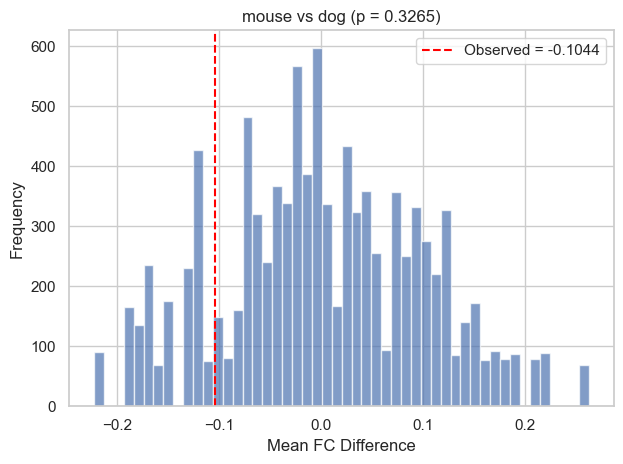

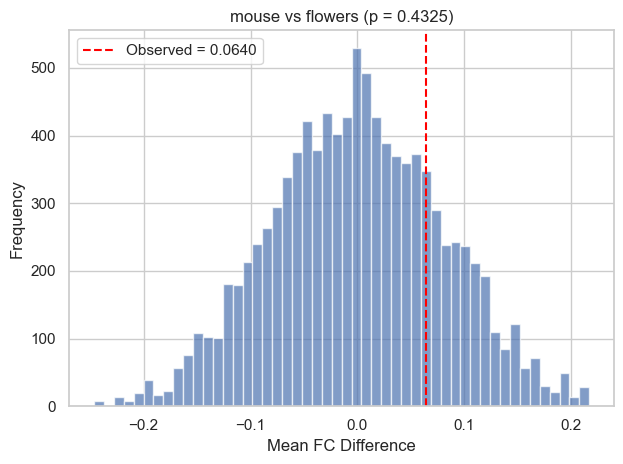

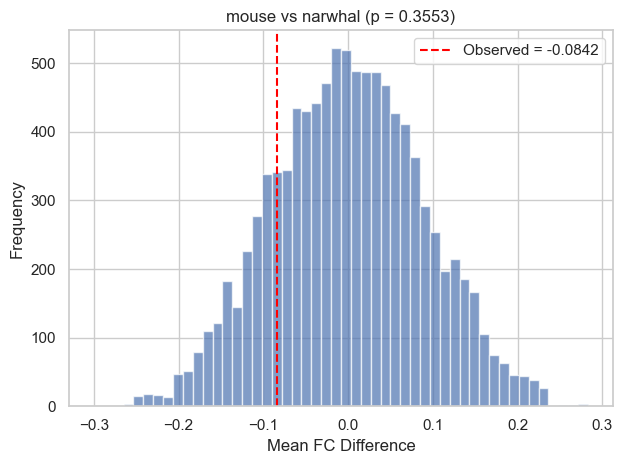

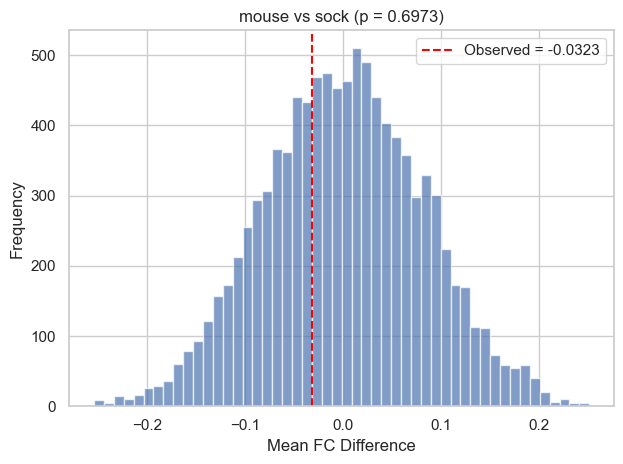

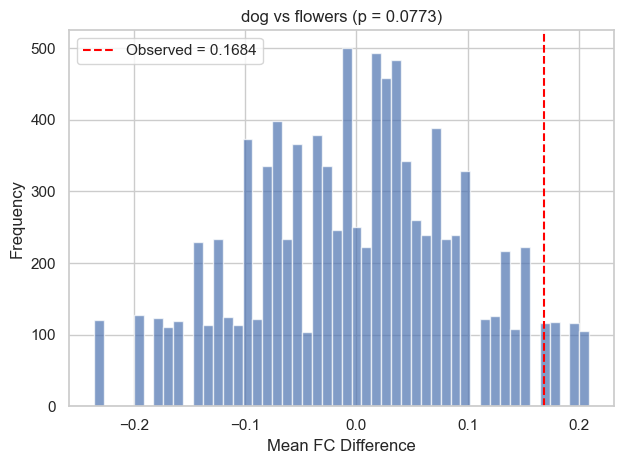

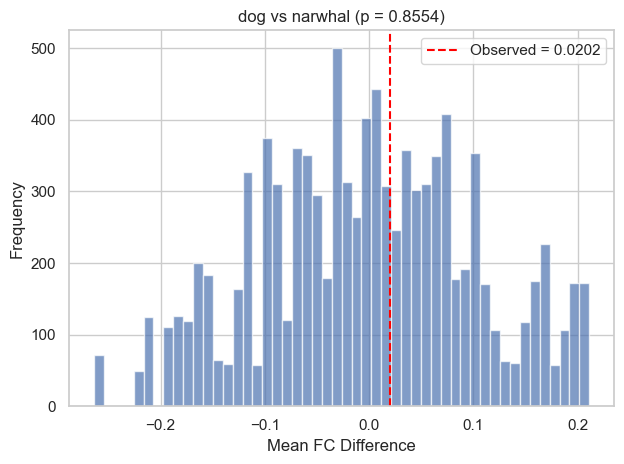

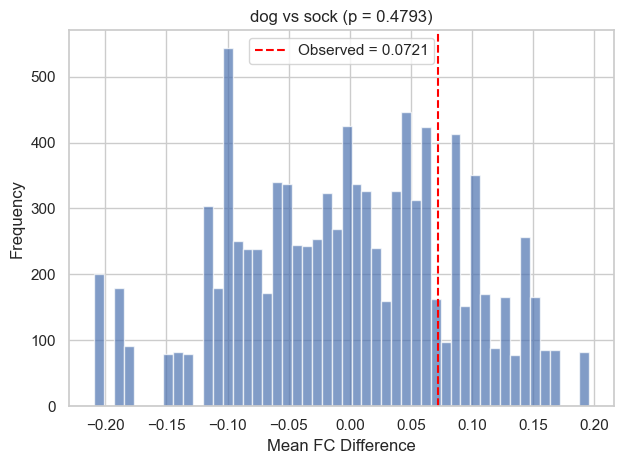

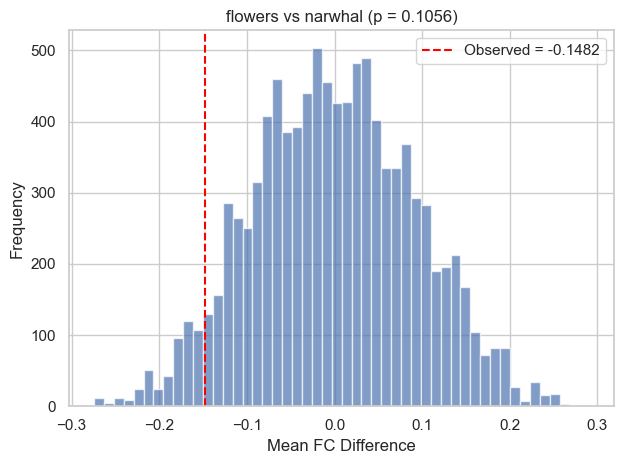

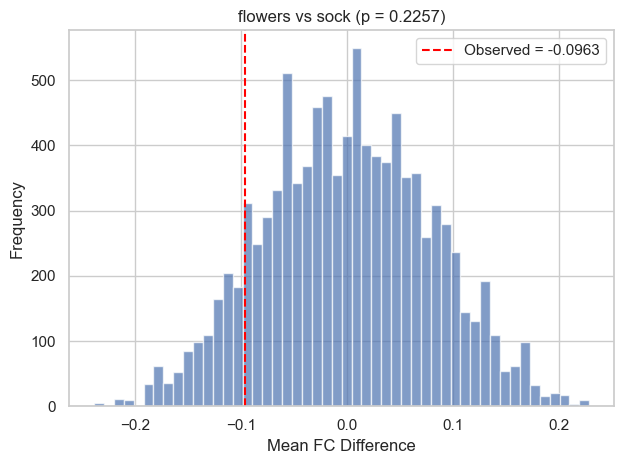

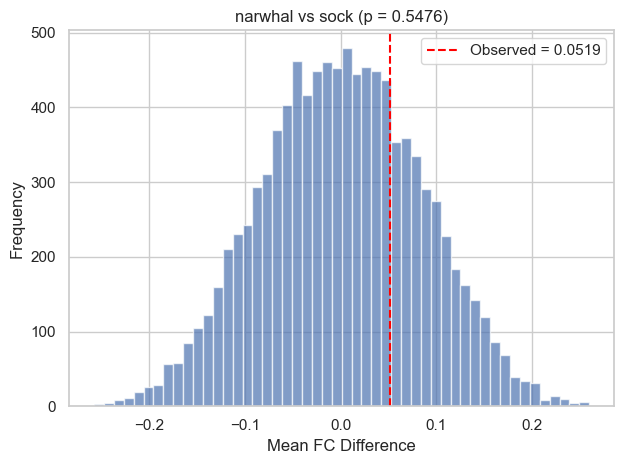

In [216]:

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

participant_group_mapping = {}

for pid in flowers_corr_matrices:
    participant_group_mapping[pid] = "flowers"

for pid in mouse_corr_matrices:
    participant_group_mapping[pid] = "mouse"

for pid in narwhal_corr_matrices:
    participant_group_mapping[pid] = "narwhal"

for pid in sock_corr_matrices:
    participant_group_mapping[pid] = "sock"

for pid in dog_corr_matrices:
    participant_group_mapping[pid] = "dog"

# Step 1: Compute mean FC (upper triangle average) for each participant
def compute_mean_fc(fc_matrix):
    triu_indices = np.triu_indices_from(fc_matrix, k=1)
    return np.mean(fc_matrix[triu_indices])

# Step 2: Group participants by book
group_fc_values = {}  

for sub_id, fc_matrix in all_corr_matrices:
    book = participant_group_mapping[sub_id]
    mean_fc = compute_mean_fc(fc_matrix)
    group_fc_values.setdefault(book, []).append(mean_fc)

# Step 3: Permutation test between each pair of books
n_permutations = 10000
results = {}

book_names = list(group_fc_values.keys())

for book1, book2 in itertools.combinations(book_names, 2):
    fc1 = np.array(group_fc_values[book1])
    fc2 = np.array(group_fc_values[book2])
    
    observed_diff = fc1.mean() - fc2.mean()
    
    # Combine and permute
    combined = np.concatenate([fc1, fc2])
    n1 = len(fc1)
    null_diffs = []
    
    for _ in range(n_permutations):
        perm = np.random.permutation(combined)
        perm_diff = perm[:n1].mean() - perm[n1:].mean()
        null_diffs.append(perm_diff)
    
    null_diffs = np.array(null_diffs)
    p_value = np.mean(np.abs(null_diffs) >= np.abs(observed_diff))
    
    results[(book1, book2)] = {
        'observed_diff': observed_diff,
        'p_value': p_value,
        'null_diffs': null_diffs
    }

    # Plot null distribution
    plt.hist(null_diffs, bins=50, alpha=0.7)
    plt.axvline(observed_diff, color='red', linestyle='dashed', label=f'Observed = {observed_diff:.4f}')
    plt.title(f'{book1} vs {book2} (p = {p_value:.4f})')
    plt.xlabel('Mean FC Difference')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Analysis #3: Permuation of Functional Connectivity Between Stories
This analysis compares average brain functional connectivity (FC) across groups of participants who each read one of five different books: flowers, mouse, narwhal, sock, or dog. For each participant, the script calculates a single mean FC value by averaging the upper triangle of their correlation matrix, which represents the overall connectivity between brain channels. Participants are then grouped according to the book they read, allowing the analysis to test whether different stories lead to different patterns of brain connectivity.

To assess group differences, the script performs permutation tests for each pair of book groups. It calculates the observed difference in mean FC between groups, then repeatedly shuffles participant group labels to generate a null distribution of differences expected by chance. The p-value is computed as the proportion of shuffled differences that are as extreme as the observed one. Histograms with the observed differences overlaid help visualize whether the group effect is likely meaningful. A low p-value suggests that the story content may significantly influence functional brain connectivity, potentially reflecting differences in cognitive engagement or emotional processing from content of different stories. 

The results of the permutation tests suggest that there are no statistically significant differences in functional connectivity (FC) between the various books. The p-values for all comparisons are above the conventional threshold of 0.05, with the lowest p-value being 0.0786 for the comparison between the dog and flower groups. This indicates that, based on the current data and analysis, the story content—whether it is Narwhal, Little Sock, Mouse House, My Dog Thinks I'm A Genius, or Why Do Flowers Grow—does not appear to have a meaningful impact on the overall brain connectivity patterns of the participants.


For most pairwise comparisons, including mouse vs. dog (p = 0.3435), mouse vs. flower (p = 0.4496), and dog vs. narwhal (p = 0.8587), the p-values are quite high, suggesting that the observed differences in FC could easily occur by chance. The only comparison approaching statistical significance is between dog and flower (p = 0.0786), but even this is not below the threshold for significance. These results suggest that in the future if there are difference in FC across groups it will not be due to story content and will ikely be due to another manipulation. As this is a pilot for a larger study our hope is that the story content will prove to not be a confound.


# Conclusion
This pilot study has provided valuable insights into the effectiveness of our story questions and their alignment with the intended cognitive difficulty. The comprehension scores indicate that, overall, our questions were clear and appropriately challenging for participants, with the notable exception of the Narwhal book, where the questions were misunderstood.   We plan to revisit and revise these questions to ensure consistency across all story types in future studies. The findings from the linear regression analysis also support the validity of the rest of our questions, as they align with the comprehension data, ensuring that the difficulty levels correspond to the intended cognitive load.

The results from the functional connectivity permutation test revealed no significant differences in brain connectivity patterns across the different books, suggesting that the type of story content itself did not significantly influence participants' functional connectivity. This lack of variation in functional connectivity is an important finding, as it implies that the future differences in brain activity will not be driven by the specific narrative content of the books. Therefore, when examining the modality of book presentation (e.g., video versus audio versus interactive), we can confidently conclude that the modality, rather than the content of the stories, is the key factor influencing neural activity. This insight strengthens our understanding of how modality impacts brain processing during narrative comprehension and provides a clearer direction for future investigations focusing on the influence of presentation format on cognitive processes.